In [1]:
import sys
sys.path.append(sys.path[0] + '/deepkexpfam')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from utils import make_grid_data, plot_object2D, plot_outrange, flow_density, object_density, find_outrange
from utils import load_object, save_object
from flows import Flow_VI

from Datasets import Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring

%matplotlib inline

In [3]:
# Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring
save_path = './saved_flows_affine_llimit_data/'

d = 1
D = 2
layers = 20

sample_size = 500
batch_size = 100
epochs = 300
lr = 0.01
weight_decay = 0

names = ['Funnel', 'Banana', 'Ring', 'Uniform', 'Cosine', 'Grid', 'Multiring']
objs = [Funnel(), Banana(), Ring(), Uniform(), Cosine(), Grid(), Multiring()]


iters = 100
n_x, n_y = 500, 500
x_interval, y_interval = np.linspace(-7, 7, n_x), np.linspace(-7, 7, n_y)
grid_x, grid_y, X = make_grid_data(x_interval, y_interval)

In [4]:
# train and save posteriors
# member_id = 0
# flows = []
# for i in range(len(names)):
#     name = names[i]
#     obj = objs[i]
    
#     flow_map = load_object(save_path+name+str(member_id))
    
#     while True:
#         try:
#             flow = Flow_VI(d, D, layers, coupling_layers='affine')
#             flow.init_params_from_flow(flow_map)
#             flow.train(obj, sample_size, batch_size, epochs, lr, weight_decay=weight_decay, show_progress=True)

#             save_object(flow, save_path+name+'VI')

#             flows.append(flow)
#         except ValueError:
#                 print('Value error')
#         except RuntimeError:
#             print('Runtime error')
#         else:
#             break

#         print(name)

    
# Compute and save/load densities for flows
# pX_dict = {}
# for i in range(len(flows)):
#     name = names[i]
#     flow = flows[i]
    
#     pX_iters = np.zeros((iters, n_x, n_y))
#     for j in range(iters):
#         flow.sample_params()
#         pX_iters[j, :, :] = flow_density(flow, X).reshape(n_x, n_y)
    
#     print(name)
#     pX_dict[name] = pX_iters

# save_object(pX_dict, save_path + 'pX_dict_VI')

pX_dict = load_object(save_path + 'pX_dict_VI')


In [5]:
# Precompute object densities
pX_objs = []
for i in range(len(names)):
    obj = objs[i]
    name = names[i]
    
    pX_obj = object_density(obj, X).reshape(n_x, n_y)
    pX_objs.append(pX_obj)
    
    print(name)

Funnel
Banana
Ring
Uniform
Cosine
Grid
Multiring


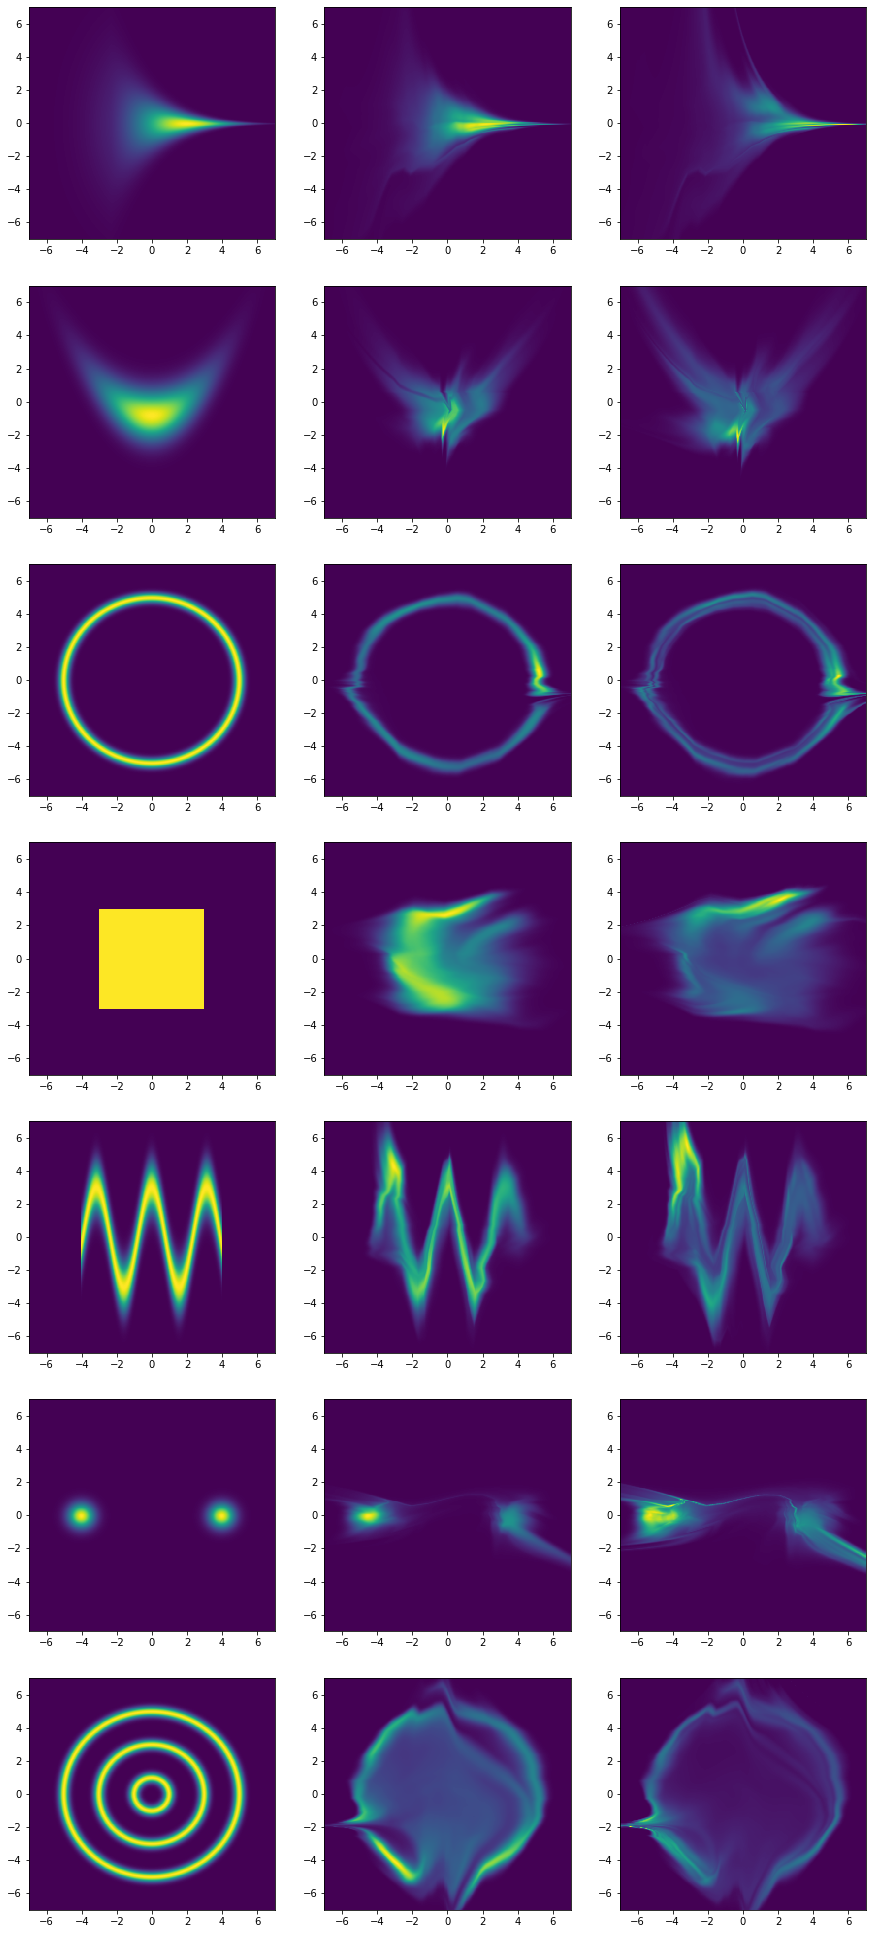

In [6]:
# plot mean and standard deviation
plt.figure(figsize=(15,35))
for i in range(len(names)):
    pX_obj = pX_objs[i]
    name = names[i]
    
    pX_iters = pX_dict[name]
    pX_mean = pX_iters.mean(axis=0)
    pX_std = pX_iters.std(axis=0)
    
    # clip large value
    #max_val = 0.1 * pX_std.max()
    #idx = pX_std > max_val
    #pX_std[idx] = max_val
    
    plt.subplot(7, 3, 3*i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    plt.subplot(7, 3, 3*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_mean, shading='auto')
    plt.subplot(7, 3, 3*i+3)
    plt.pcolormesh(grid_x, grid_y, pX_std, shading='auto')

overall std = 0.0011


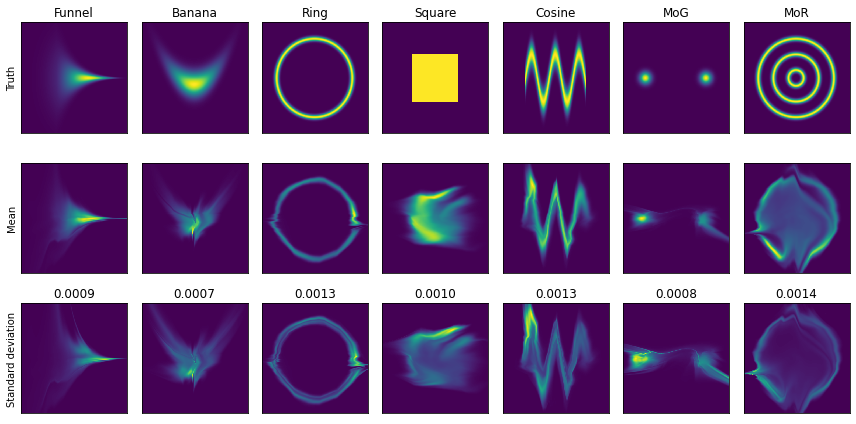

In [7]:
# plot mean and standard deviation
plot_names = ['Funnel', 'Banana', 'Ring', 'Square', 'Cosine', 'MoG', 'MoR']

plt.figure(figsize=(12, 6))
for i in range(len(names)):
    pX_obj = pX_objs[i]
    name = names[i]
    plot_name = plot_names[i]
    
    pX_iters = pX_dict[name]
    pX_mean = pX_iters.mean(axis=0)
    pX_std = pX_iters.std(axis=0)
    
    # clip large value
    #max_val = 0.1 * pX_std.max()
    #idx = pX_std > max_val
    #pX_std[idx] = max_val
    
    plt.subplot(3, 7, i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    plt.title(plot_name)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3, 7, i+8)
    plt.pcolormesh(grid_x, grid_y, pX_mean, shading='auto')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Mean')
    
    plt.subplot(3, 7, i+15)
    plt.title('%.4f' % pX_std.mean())
    plt.pcolormesh(grid_x, grid_y, pX_std, shading='auto')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Standard deviation')

plt.tight_layout()

overall_std = []
for i in range(len(names)):
    name = names[i]
    pX_iters = pX_dict[name]
    std = pX_iters.std(axis=0).mean()
    overall_std.append(std)
print('overall std = %.4f' % np.mean(overall_std))

In [8]:
# Precompute outranges for all objects
conf_intervals = [10, 50, 90]

pX_outranges_dict = {}
for i in range(len(names)):
    name = names[i]
    
    pX_obj = pX_objs[i]
    pX_iters = pX_dict[name]
    
    pX_outranges = []
    for conf_interval in conf_intervals:
        pX_outrange = find_outrange(pX_obj, pX_iters, conf_interval)
        pX_outranges.append(pX_outrange)
    
    pX_outranges_dict[name] = pX_outranges
    
    print(name)

Funnel
Banana
Ring
Uniform
Cosine
Grid
Multiring


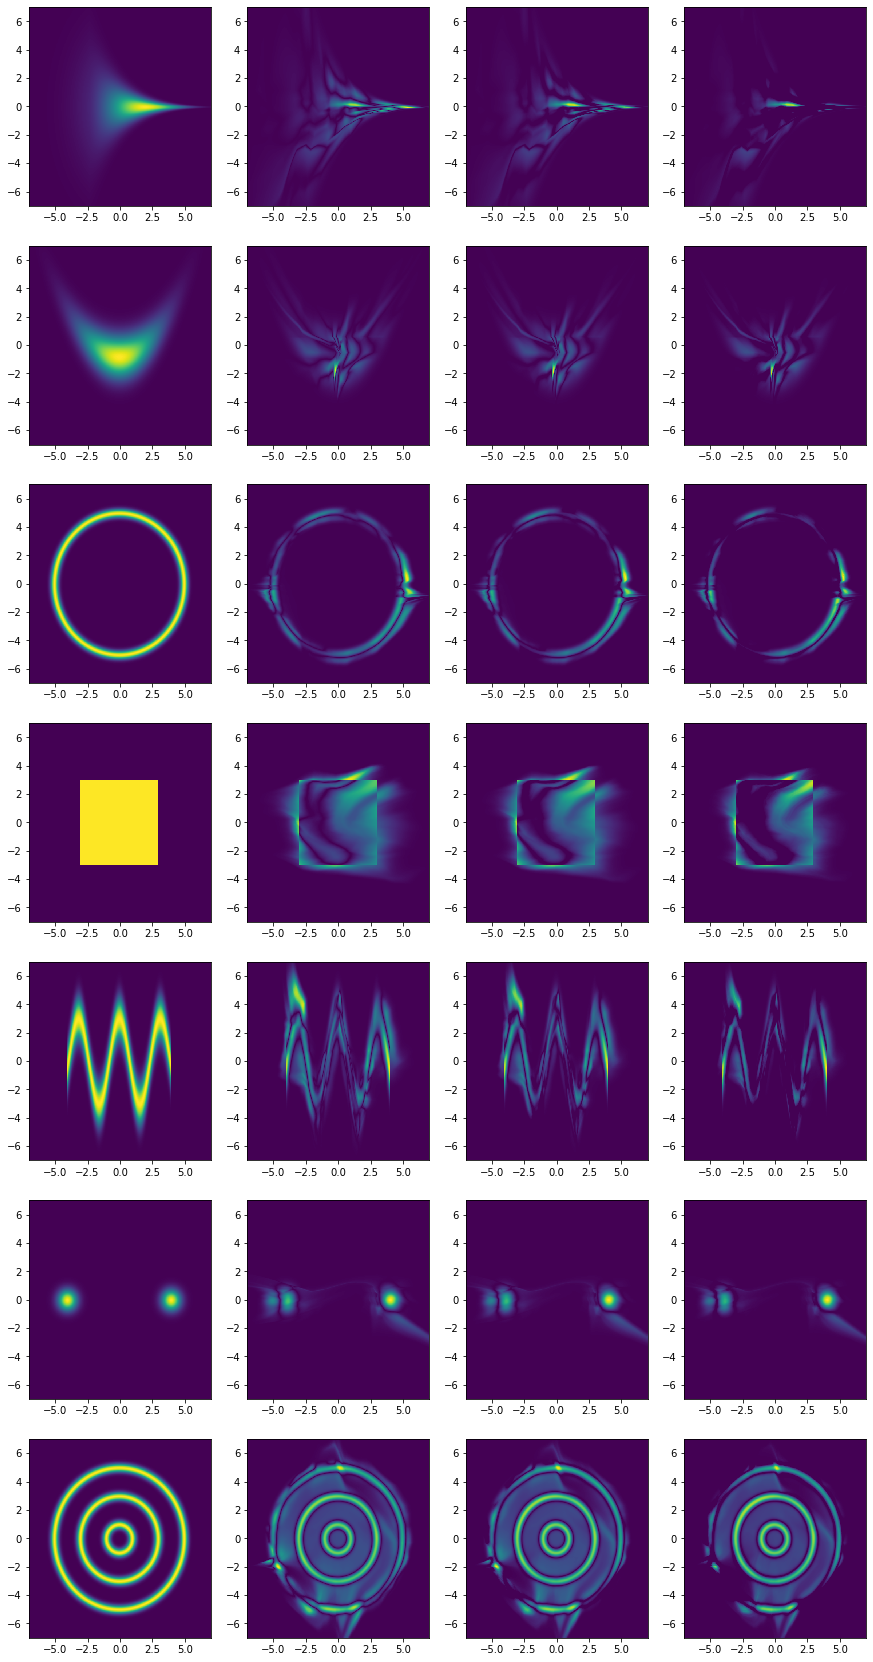

In [9]:
# Plot confidence interval
plt.figure(figsize=(15,30))
for i in range(len(names)):
    name = names[i]
    
    obj = objs[i]
    pX_obj = pX_objs[i]
    
    pX_iters = pX_dict[name]
    pX_outranges = pX_outranges_dict[name]
    
    plt.subplot(7, 4, 4*i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    
    plt.subplot(7, 4, 4*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[0], shading='auto')
    plt.subplot(7, 4, 4*i+3)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[1], shading='auto')
    plt.subplot(7, 4, 4*i+4)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[2], shading='auto')

In [10]:
table = {}
for i in range(len(names)):
    name = names[i]
    pX_outranges = pX_outranges_dict[name]
    means = []
    for j in range(len(conf_intervals)):
        means.append(pX_outranges[j].mean())
    table[name] = means


print('\t\t', end='')
for conf_interval in conf_intervals:
    print(str(conf_interval) + '%', end='\t')

print('')

for name in names:
    print(name, end='    ')
    for mean in table[name]:
        print('\t%2.2f' % (mean*1e6), end='')
    
    print('')
    
print('\nAverage deviation from confidence interval * 1e6')

		10%	50%	90%	
Funnel    	836.61	580.64	230.53
Banana    	1633.54	1394.36	934.87
Ring    	3172.84	2553.80	1664.08
Uniform    	2472.39	2046.44	1352.30
Cosine    	2345.88	1822.31	1069.71
Grid    	3928.85	3559.54	2935.20
Multiring    	4491.85	3873.21	3024.37

Average deviation from confidence interval * 1e6


In [11]:
table = {}
for i in range(len(names)):
    name = names[i]
    pX_outranges = pX_outranges_dict[name]
    means = []
    for j in range(len(conf_intervals)):
        means.append(np.mean(pX_outranges[j] == 0.))
    table[name] = means


print('\t\t', end='')
for conf_interval in conf_intervals:
    print(str(conf_interval) + '%', end='\t')

print('')

for name in names:
    print(name, end='    ')
    for mean in table[name]:
        print('\t%2.2f' % (mean), end='')
    
    print('')

print('')
    
print('Overall', end='    ')

for i in range(len(conf_intervals)):
    column = []
    for name in table:
        column.append(table[name][i])
    print('\t%2.2f' % (np.mean(column)), end='')

print('')
    
print('\npercentage of pixels inside confidence interval')

		10%	50%	90%	
Funnel    	0.16	0.24	0.46
Banana    	0.01	0.07	0.23
Ring    	0.02	0.09	0.25
Uniform    	0.47	0.50	0.56
Cosine    	0.22	0.32	0.49
Grid    	0.02	0.11	0.33
Multiring    	0.02	0.08	0.21

Overall    	0.13	0.20	0.36

percentage of pixels inside confidence interval
